# 一、目标检测任务解决正负样本不均衡问题的手段有哪些？

## 1.1 正负样本不均衡
- 当前基于深度学习的目标检测主要包括：基于Two-stage的目标检测和基于One-stage的目标检测。Two-stage的目标检测框架一般检测精度相对较高，但检测速度慢；而One-stage的目标检测速度相对较快，但是检测精度相对较低。One-stage的精度不如Two-stage的精度，一个主要的原因是训练过程中样本极度不均衡造成的。
- 在目标检测中，正样本指的是图片中感兴趣的目标区域，负样本指的是目标区域之外的背景区域。
- 不均衡：指在训练的时候各个类别的样本数量不均衡。所谓的样本不平衡问题是指在训练的时候各个类别的样本数量极不均衡。以基于深度学习的单阶段目标检测为例，样本类别不均衡主要体现在两方面：正负样本不均衡（正负样本比例达到1:1000）和难易样本不均衡（简单样本主导loss）。一般在目标检测任务框架中，保持正负样本的比例为1:3（经验值）。
- - - - - - -
目标检测任务中，样本类别通常划分为：
- 正样本：标签区域内的图像区域，即目标图像块；
- 负样本：标签区域以外的图像区域，即图像背景区域；
- 易分正样本：容易正确分类的正样本，在实际训练过程中，该类占总体样本的比重非常高，单个样本的损失函数较小，但是累计的损失函数会主导损失函数；
- 易分负样本：容易正确分类的负样本，在实际训练过程中，该类占的比重非常高，单个样本的损失函数较小，但是累计的损失函数会主导损失函数；
- 难分正样本：错分成负样本的正样本，这部分样本在训练过程中单个样本的损失函数教高，但是该类占总体样本的比例教小；
- 难分负样本：错分成正样本的负样本，这部分样本在训练过程中单个样本的损失函数教高，但是该类占总体样本的比例教小。

## 1.2 解决方案
### 1.OHEM:Training Region-based Object Detectors with Online Hard Example Mining

OHEM算法（Online Hard Example Mining，发表于2016年的CVPR）主要是针对训练过程中的困难样本自动选择，其核心思想是根据输入样本的损失进行筛选，筛选出困难样本（即对分类和检测影响较大的样本），然后将筛选得到的这些样本应用在随机梯度下降中训练。在实际操作中是将原来的一个ROI Network扩充为两个ROI Network，这两个ROI Network共享参数。其中前面一个ROI Network只有前向操作，主要用于计算损失；后面一个ROI Network包括前向和后向操作，以hard example作为输入，计算损失并回传梯度。该算法在目标检测框架中被大量使用，如Fast RCNN。

该算法的优点：

-    1.对于数据的类别不平衡问题不需要采用设置正负样本比例的方式来解决，这种在线选择方式针对性更强；

-    2.随着数据集的增大，算法的提升更加明显。

该算法的缺点：
-    只保留 loss 较高的样本，完全忽略简单的样本，这本质上是改变了训练时的输入分布（仅包含困难样本），这会导致模型在学习的时候失去对简单样本的判别能力。
- - - - - - -
### 2.S-OHEM:Stratified Online Hard Example Mining for Object Detection S-OHEM

S-OHEM 方法（发表于 2017 年的 CCCV），主要考虑 OHEM 训练过程忽略了不同损失分布的影响，因此 S-OHEM 根据 loss 的分布抽样训练样本。它的做法是将预设 loss 的四个分段：给定一个 batch，先生成输入 batch 中所有图像的候选 RoI，再将这些 RoI 送入到 Read only RoI 网络得到 RoIs 的损失，然后将每个 RoI 根据损失（这里损失是一个组合，具体公式为L_"select " =α×L_cls+β×L_"loc" ，α，β 随着训练阶段变化而变化。之所以采用这个公式是因为在训练初期阶段，分类损失占主导作用；在训练后期阶段，边框回归损失函数占主导作用）划分到上面四个分段中，然后针对每个分段，通过排序筛选困难样本。再将经过筛选的 RoIs 送入反向传播，用于更新网络参数。

该算法的优点：
- 相比原生 OHEM，S-OHEM 考虑了基于不同损失函数的分布来抽样选择困难样本，避免了仅使用高损失的样本来更新模型参数。

该算法的缺点：
- 因为不同阶段，分类损失和定位损失的贡献不同，所以选择损失中的两个参数 α，β 需要根据不同训练阶段进行改变，当应用与不同数据集时，参数的选取也是不一样的．即引入了额外的超参数。
- - - - - - -
### 3.A-Fast-RCNN:Hard positive generation via adversary for object detection

从更好的利用数据的角度出发，OHEM 和 S-OHEM 都是发现困难样本，而 A-Fast-RCNN的方法（发表于2017年CVPR）则是通过 GAN 的方式在特征空间产生具有部分遮挡和形变的困难样本，而这部分样本数据很难出现在实际训练数据集中。

该算法的优点：
- 与 OHEM 相比，区别在于文本的方法是构建不存在的 Hard Poistive 样本，而 OHEM 是挖掘现有样本中的 Hard 样本。

该算法的缺点：
- 从改善效果上来讲，A-Fast-RCNN 的方法的效果并不比 OHEM 好太多，也许是仿造的数据和真实性还存在差距，此外 GAN 网络也比较难训练。
- - - - - - -
### 4.Focal Loss:Focal Loss for Dense Object Detection
- - - - - - -
### 5.GHM:Gradient Harmonized Single-stage Detector

# 二、对比yolov1、yolov2、yolov3、yolov4、yolov5五个模型

## 1.yolov1
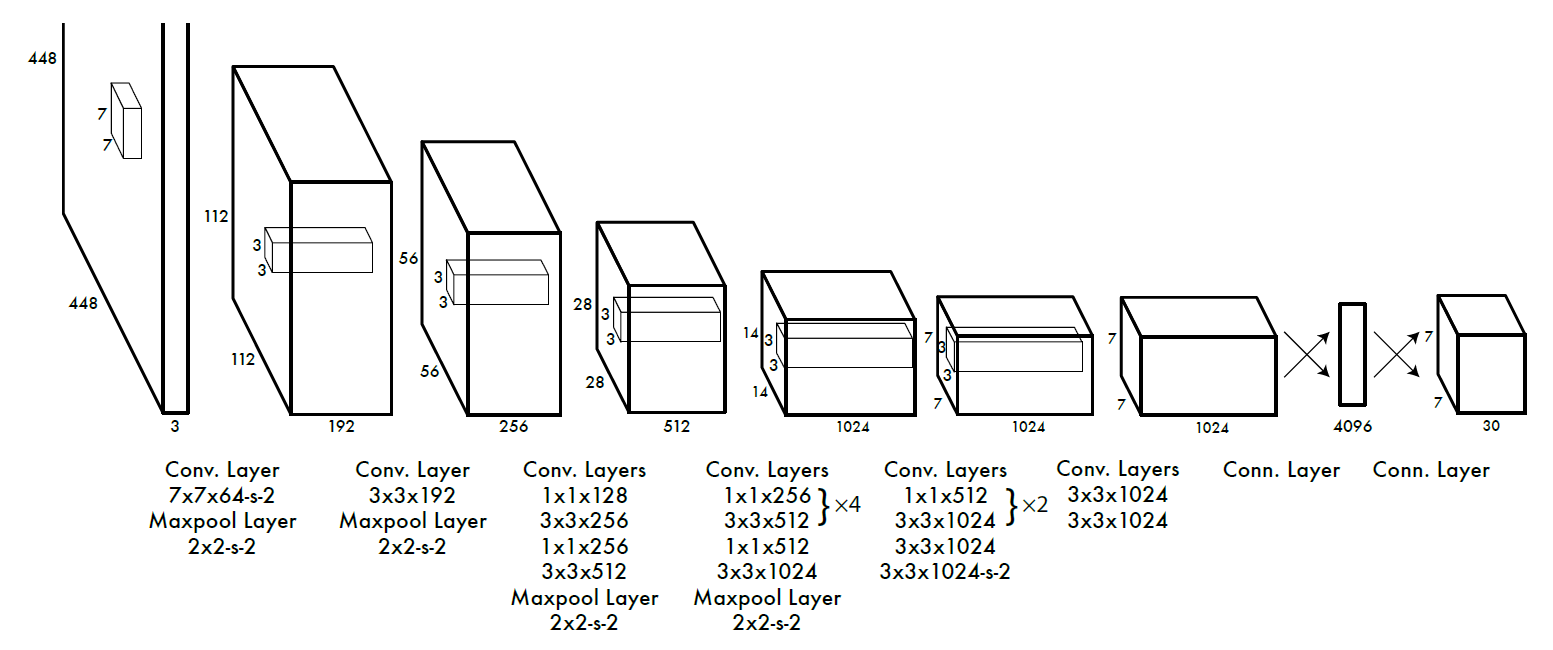

## 2.yolov2
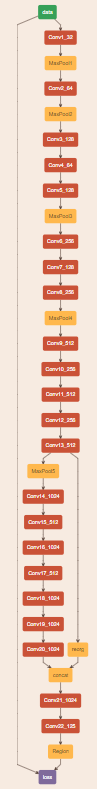

## 3.yolov3
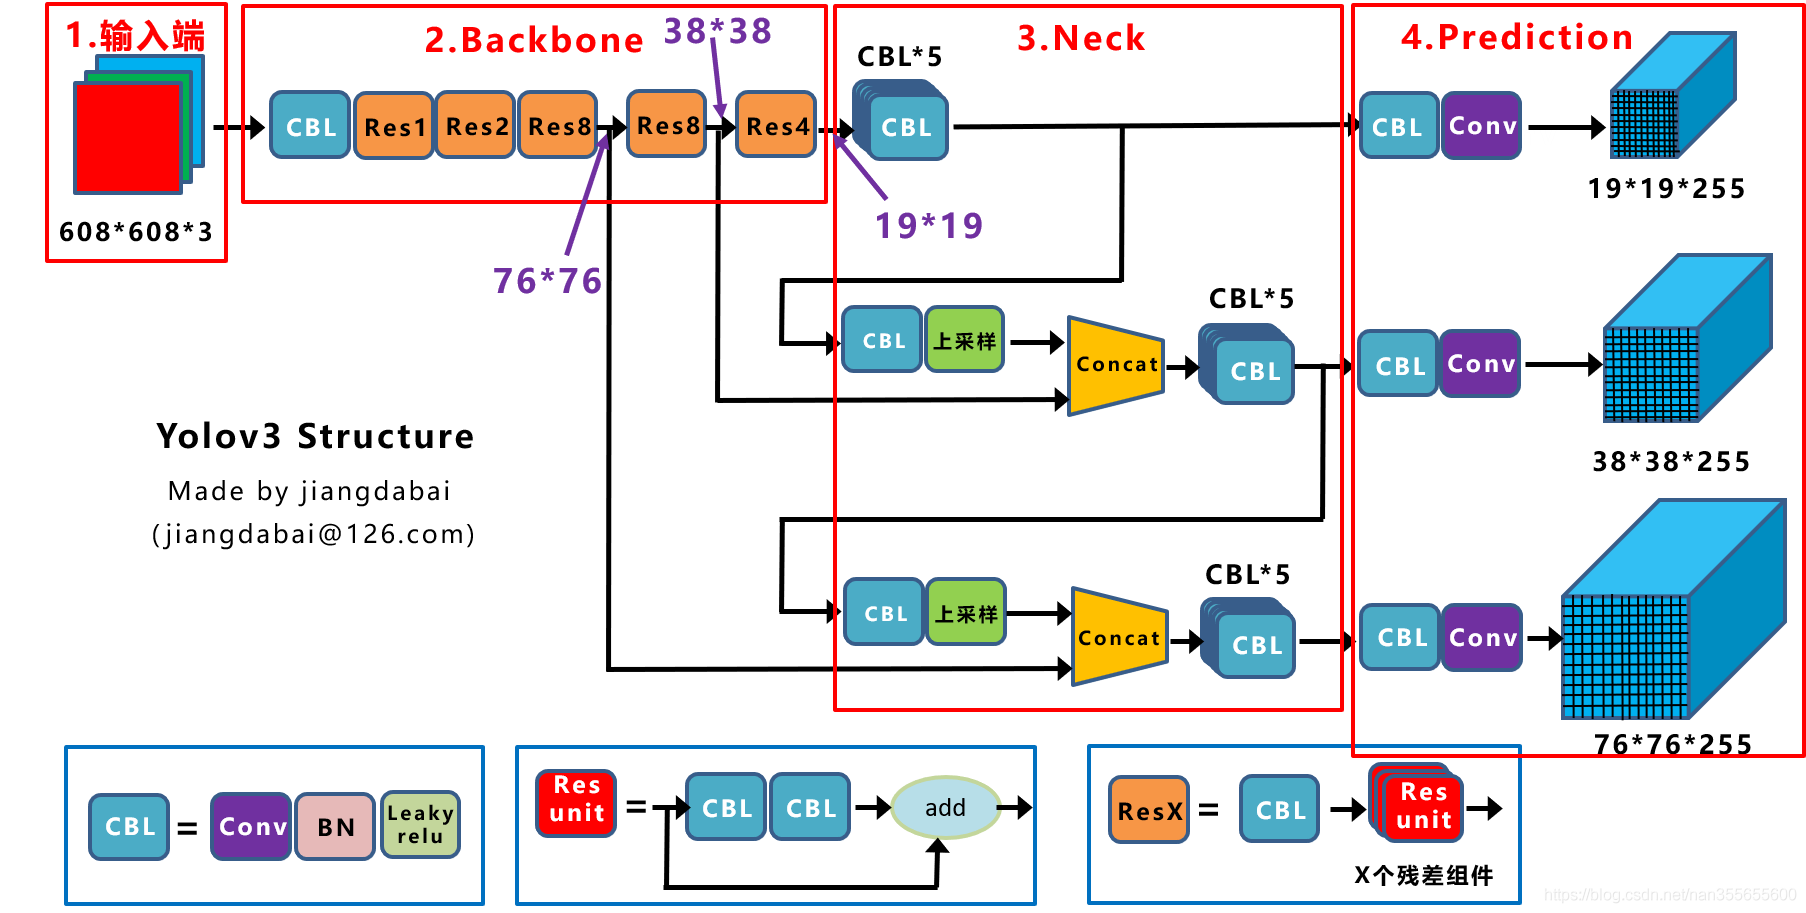

## 4.yolov4
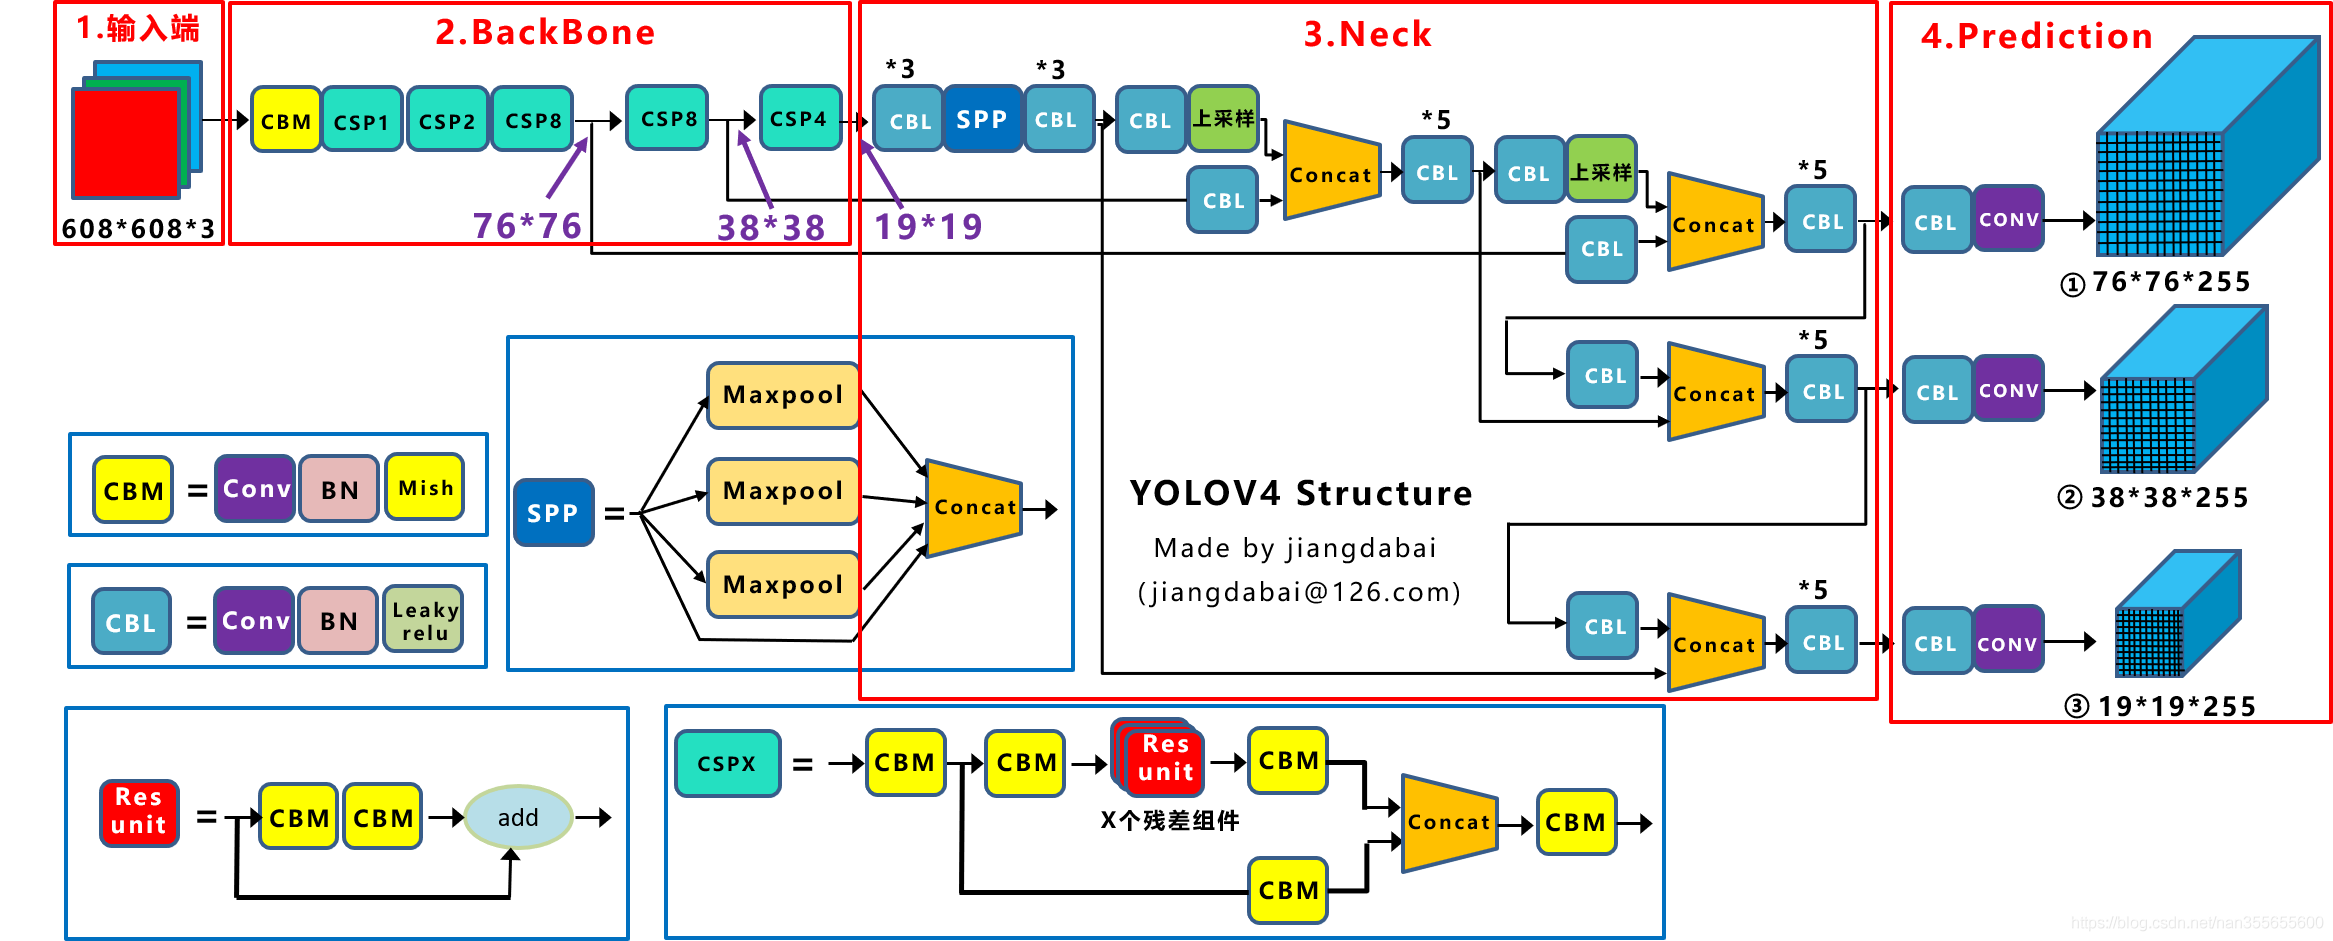

## 5.yolov5
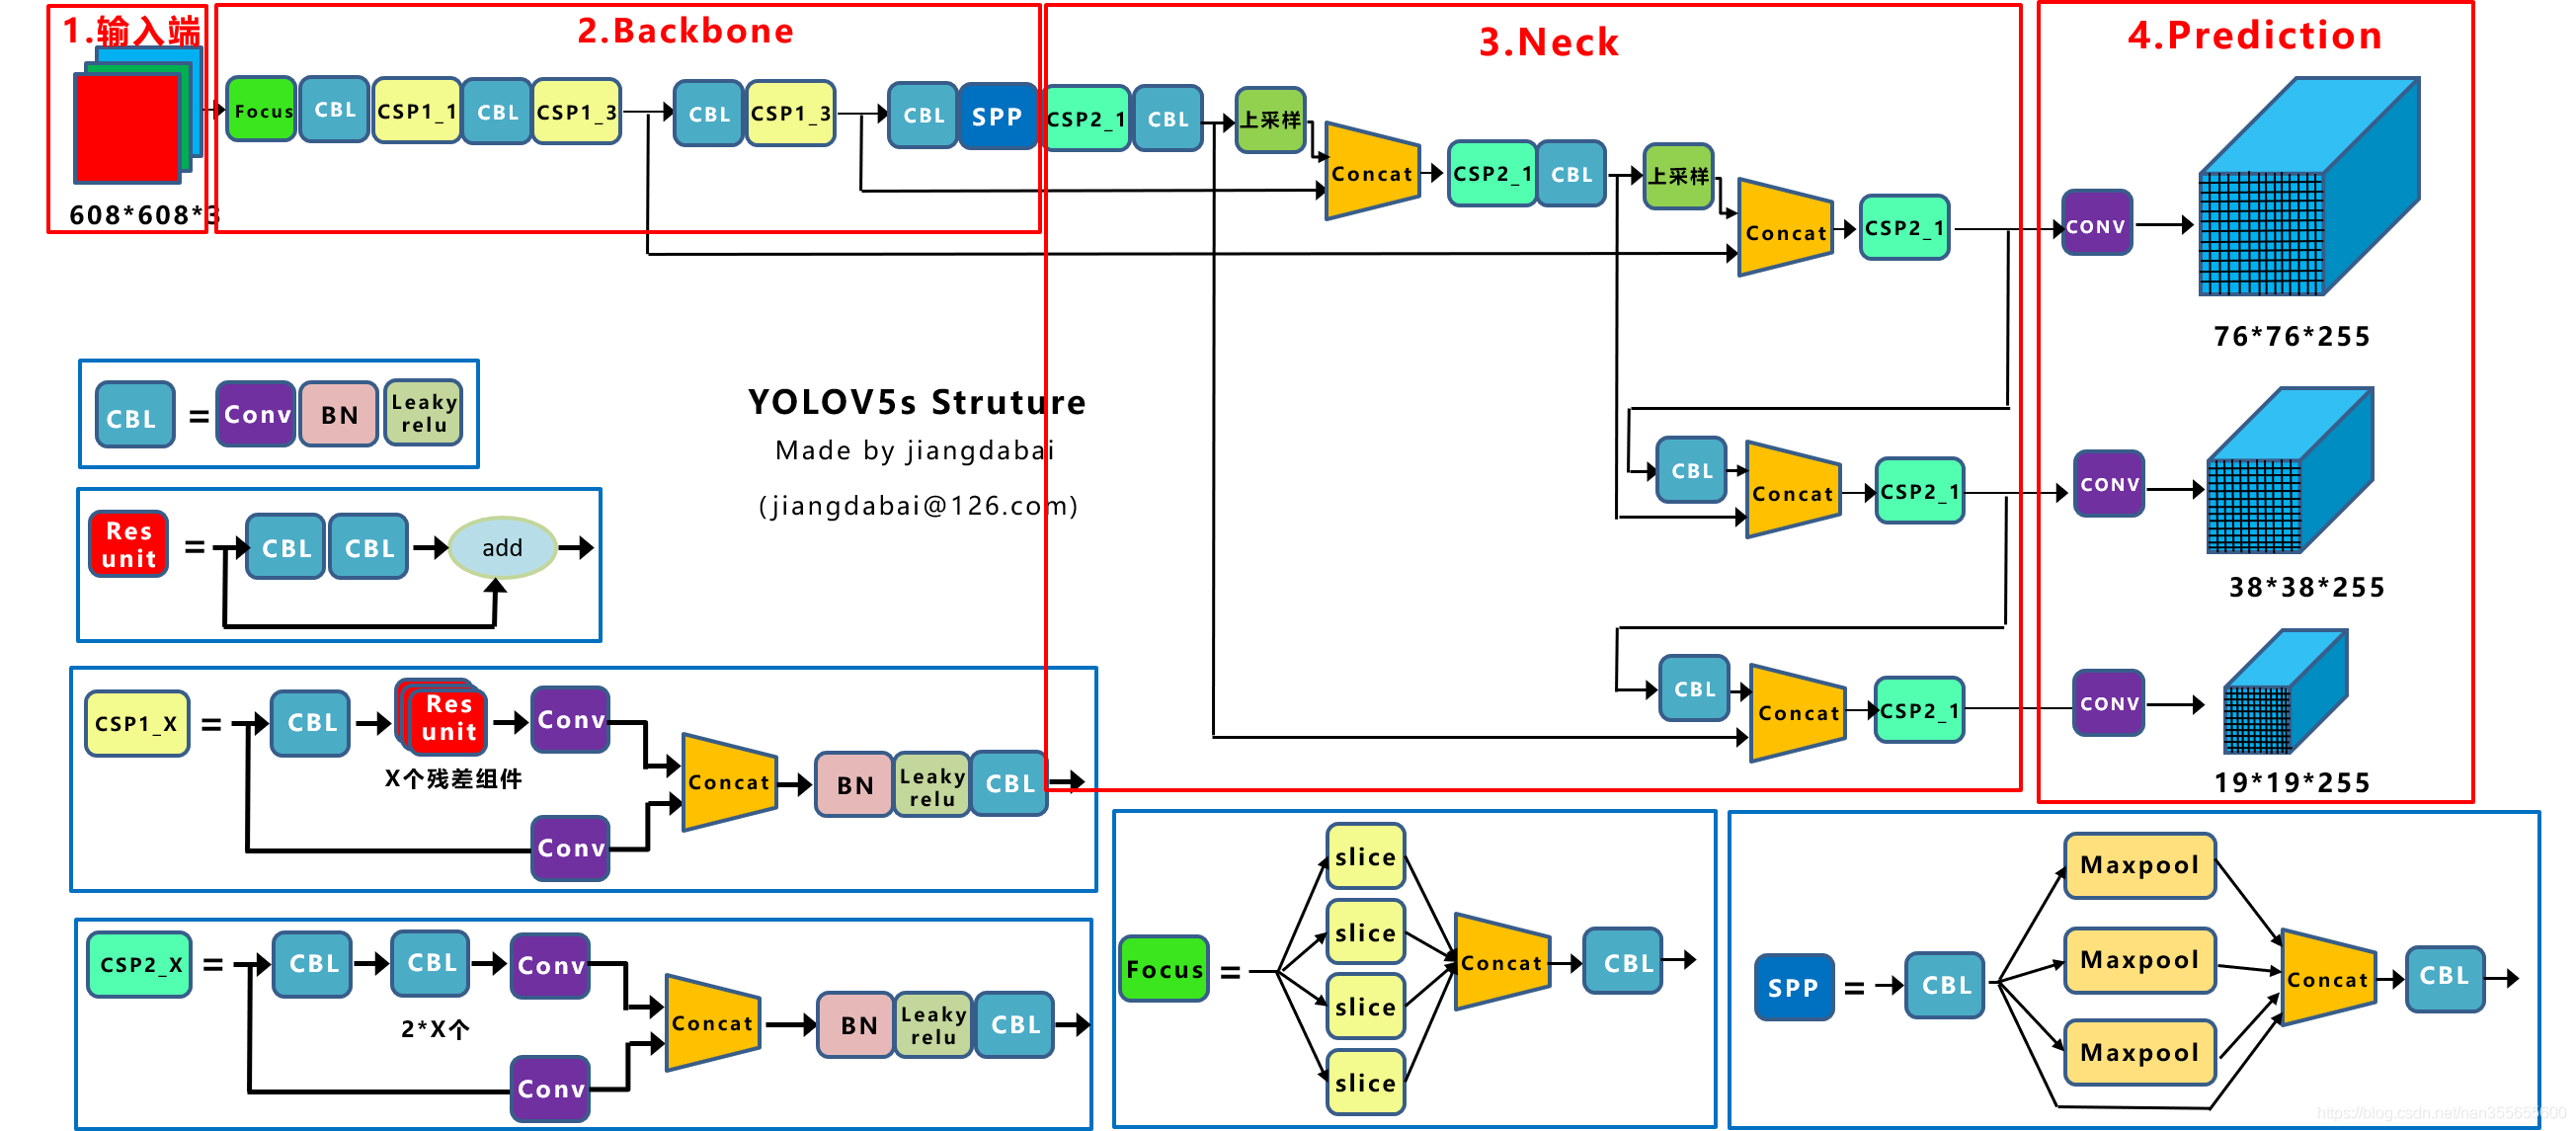

# 三、两阶段目标检测模型Faster-RCNN

- 以下内容参考：Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks
- Faster-RCNN的基本结构
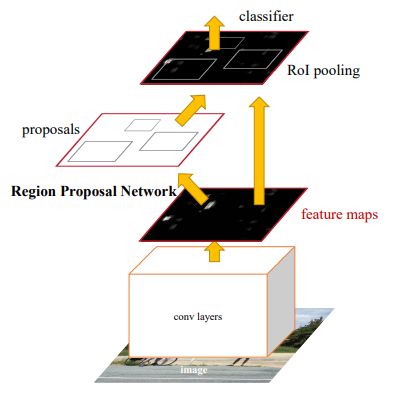

#  四、单阶段目标检测模型yolov5

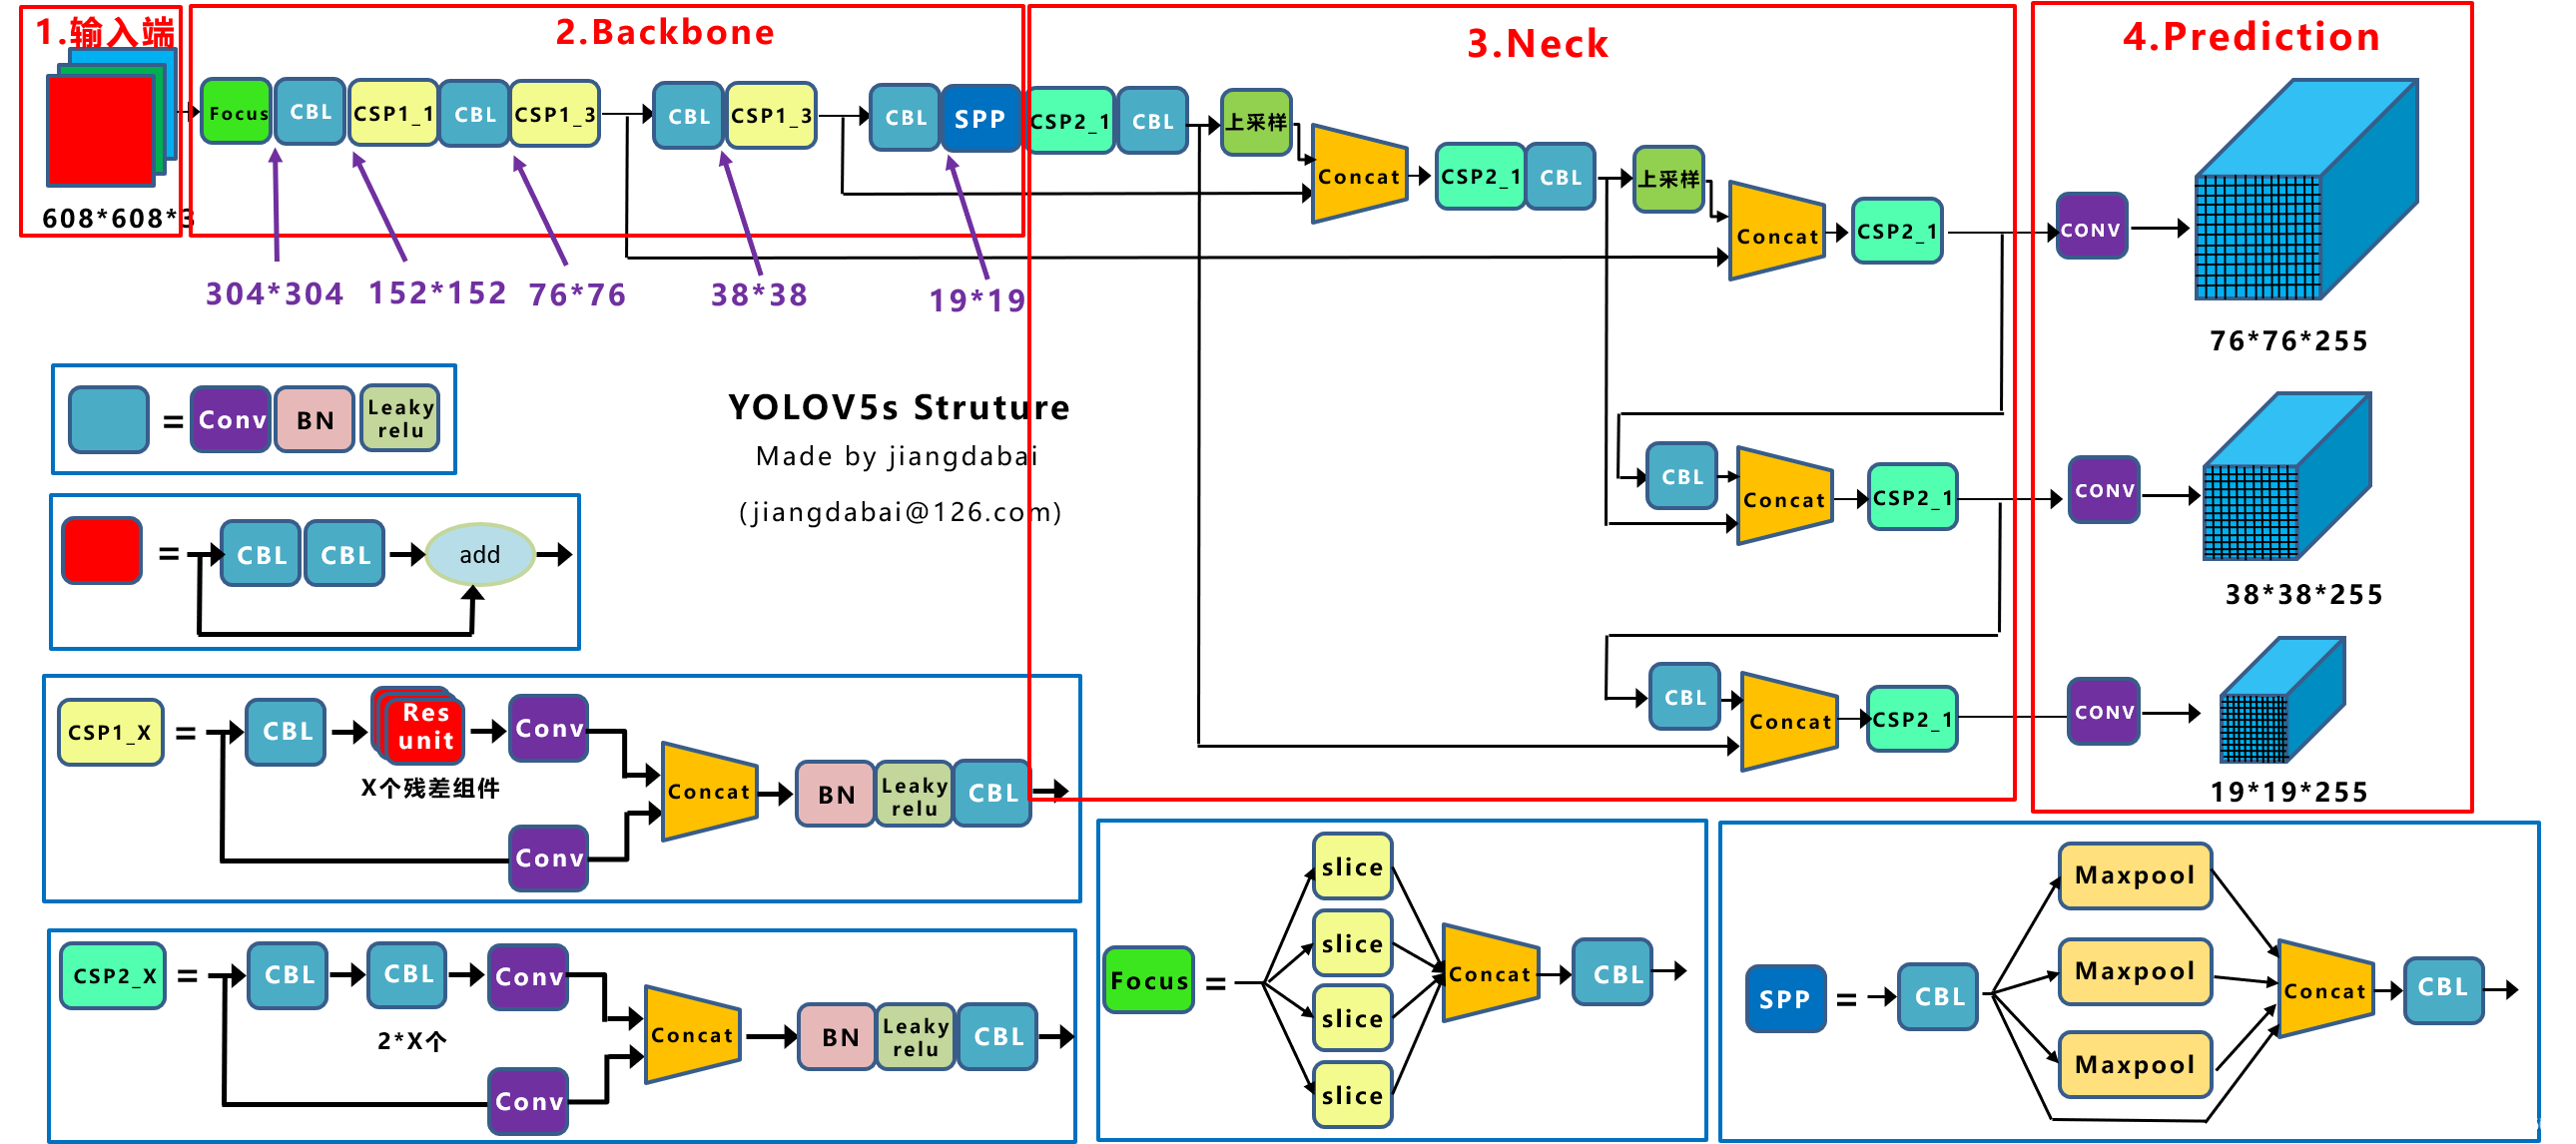